# INTRO TO RASTERS!

In this notebook we will learn to do a some basic raster manipulation:

### 1. Open rasters and look at some of their basic information
We will take a look at both a single band and a multi band raster.
The library we will use for handling rasters wil be [rioxarray](https://corteva.github.io/rioxarray/stable/index.html), which stands for *raster input/output + xarray*. 

This builds on the [xarray](https://docs.xarray.dev/en/stable/getting-started-guide/why-xarray.html) package, which allows you to work with labelled arrays,
     
### 2. Open a GEOJSON file and look at some of its basic info
For this we will use [geopandas](https://geopandas.org/en/stable/docs.html) another popular geospatial Python library. We will compare the shapefile's CRS with the raster CRS and match them.

### 3. Clip rasters using the shapefile
The original rasters are kind of big and we are only interested in a few blocks around NCEAS. 

### 4. Compute Normalized Difference Vegetation Index (NDVI)
We will use the smaller rasters to compute the NDVI aroudn NCEAS. The NDVI is an index commonly used to check if an area has live green vegetation or not. It can also show the difference between water, plants, bare soil, and human-made structures, among other things. 

### 5. Save our NDVI raster
To do this we will use the [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) package. 


## REFERENCES:

### Data
The images we will use today come from the US National Agriculture Imagery Program (NAIP). They are high-resolution aerial images with four spectral bands: Red, Green, Blue and Near-Infrared. To prepare the rasters for this workshop I accessed the [NAIP Dataset on Microsoft's Planetary Computer](https://planetarycomputer.microsoft.com/dataset/naip#overview), where I also did some pre-processing of the data. 

### Code
Some of the code and text in this notebook, and the information on the slides is based on the workshop *Introduction to Geospatial Raster and Vector Data with Python* from the [The Carpentries Incubator](https://carpentries-incubator.github.io/geospatial-python/). This is a great resource to go deeper into working with geospatial data with Python. 

## FURTHER READING:
In the readme file for this project you can find:
- references to the `xarray`, `geopandas` and `rasterio` project developments. 
- some websites that go into depth about NDVI
- more resources to learn how to work with rasters and shapefiles!

# 0. Import libraries

In [1]:
import xarray 
import rioxarray as rioxr
import rasterio

import geopandas as gpd
from shapely.geometry import shape

import numpy as np
import matplotlib.pyplot as plt

In [2]:
#%load_ext watermark
#%watermark --iversions

# 1. Open rasters and look at some of their basic information

### OPEN NEAR-INFRARED RASTER
The first call to `rioxarray.open_rasterio()` opens the file and returns a `xarray.DataArray` that we store in a variable `nir`. You can use an `xarray.DataArray` in calculations just like a numpy array. Calling the variable name of the `xarray.DataArray` also prints out all of its metadata information.

In [3]:
nir_fp = "/home/jovyan/PlanetComp_NAIP2/naip_reduced/nir_reduced2.tif"
    
nir = rioxr.open_rasterio(nir_fp)
nir

<xarray.DataArray (band: 1, y: 3208, x: 2419)>
[7760152 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

### LOOKING AT METADATA

The `nir` object also has some attributes, like `.rio.crs`, which contain geospatial metadata for the file we opened. Note that many of the metadata are accessed as attributes without `()`, but `.rio.bounds()` and `.rio.transform()` are functions and need parentheses.

In [4]:
print('shape: ', nir.shape)
print('# bands: ', nir.rio.count)
print('height: ', nir.rio.height)
print('width: ', nir.rio.width, '\n')

print('data type: ', nir.dtype, '\n')

print('spatial bounding box: ')
print(nir.rio.bounds(), '\n')

print('affine transform: ')
print(nir.rio.transform(), '\n')

print('CRS: ', nir.rio.crs)

shape:  (1, 3208, 2419)
# bands:  1
height:  3208
width:  2419 

data type:  uint8 

spatial bounding box: 
(251218.8, 3811027.2, 252670.19999999998, 3812952.0) 

affine transform: 
| 0.60, 0.00, 251218.80|
| 0.00,-0.60, 3812952.00|
| 0.00, 0.00, 1.00| 

CRS:  EPSG:26911


### RESHAPING

Lots of useful information there! Notice the shape of the array is (1,6111,4702). The first number is telling us this raster has a single band. We don't really need to keep track of this single band, which is making the array unnecessarily three-dimensional. So we will drop that band:

In [5]:
print('original shape: ', nir.shape)
nir = nir.squeeze()
print('squeezed shape: ', nir.shape)

original shape:  (1, 3208, 2419)
squeezed shape:  (3208, 2419)


### LOOKING AT THE NIR DATA
We can examine the raw values of the array with `.values`:

In [6]:
print(type(nir.values))
nir.values

<class 'numpy.ndarray'>


array([[167, 164, 161, ..., 147, 152, 151],
       [170, 170, 168, ..., 151, 149, 154],
       [176, 177, 177, ..., 151, 151, 151],
       ...,
       [ 94,  88, 101, ...,  83,  88,  79],
       [108,  95, 103, ...,  92,  91,  75],
       [ 94,  90, 104, ...,  87,  88,  82]], dtype=uint8)

This can give us a quick view of the values of our array, but only at the corners. Since our raster is loaded in python as a `DataArray` type, we can plot this in one line similar to a pandas `DataFrame` with `DataArray.plot()`.  

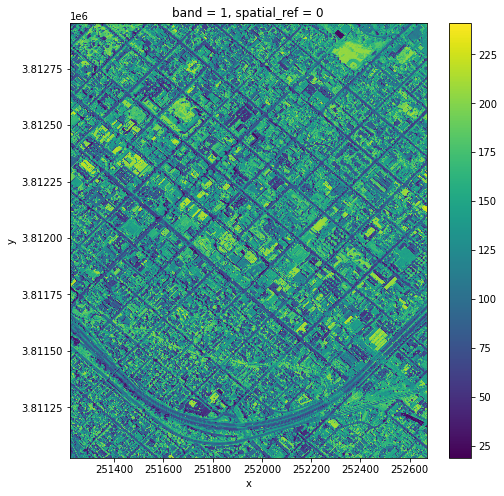

In [7]:
nir.plot(figsize=(8,8))

This map shows the light captured in the near-infrared spectrum by a sensor on a plane. **Can you guess where this?** If you guessed Santa Barbara downtown, you guessed right! 

Notice that `rioxarray` helpfully allows us to plot this raster with spatial coordinates on the x and y axis (this is not the default in many cases with other functions or libraries).

## OPENING RGB RASTER

Now let's open the RGB raster. What can you tell is different?

In [8]:
rgb_fp = "/home/jovyan/PlanetComp_NAIP2/naip_reduced/rgb_reduced2.tif"

rgb = rioxr.open_rasterio(rgb_fp)
rgb

<xarray.DataArray (band: 3, y: 3208, x: 2419)>
[23280456 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.527e+05 2.527e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.811e+06 3.811e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

Indeed, this raster's metadata is telling us it has 3 bands. This makes sense becayuse we know these should be the Red, Green and Blue bands of the image. We could have also checked this info by looking directly at the attributes:

In [9]:
print('rgb shape: ', rgb.shape)
print('rgb # bands: ', rgb.rio.count)

rgb shape:  (3, 3208, 2419)
rgb # bands:  3


It’s always a good idea to examine the shape of the raster array you are working with and make sure it’s what you expect. Many functions, especially ones that plot images, expect a raster array to have a particular shape.

## LOOKING AT THE RGB DATA

Because we know this has three bands, we can plot it as an image using `xarray.plot.imshow`, which will interpret the three bands of the object as RGB.

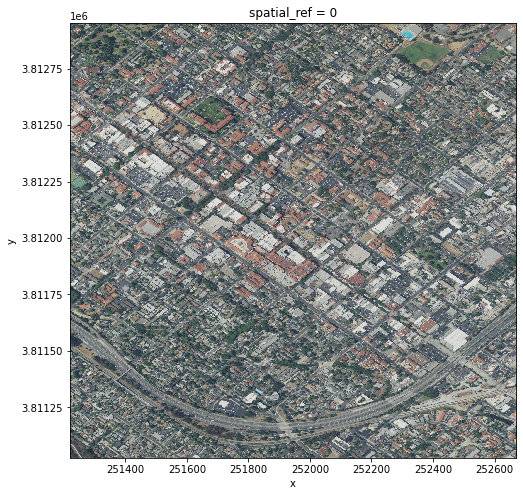

In [10]:
rgb.plot.imshow(figsize=(8,8))

# 2. Open a shapefile and look at some of its basic info

The shapefile we will open contains the boundary of our Area Of Interest (aoi) which is a few blocks around the NCEAS building. To import shapefiles we use the `geopandas` function `read_file()`.



In [11]:
aoi_fp = "/home/jovyan/PlanetComp_NAIP2/nceas_aoi/nceas_aoi.shp"
aoi = gpd.read_file(aoi_fp)
aoi

,FID,geometry
0,0,"POLYGON ((-119.70875 34.42135, -119.70875 34.4..."


When we import the shapefile layer into Python (as our `aoi` object) it comes in as a `GeoDataFrame`. The function `read_file()` automatically stores geospatial information about the data. Key metadata for all shapefiles include:

- Object Type: the class of the imported object.
- Coordinate Reference System (CRS): the projection of the data.
- Extent: geographic area that the shapefile covers.

In [12]:
print('type: ', aoi.type, '\n')
print('bounds', aoi.bounds, '\n')
print('CRS: ', aoi.crs)

type:  0    Polygon
dtype: object 

bounds          minx       miny        maxx       maxy
0 -119.708748  34.421346 -119.694632  34.429407 

CRS:  epsg:4326


We can also take a quick look at it and see it is a rectangle!

<AxesSubplot:>

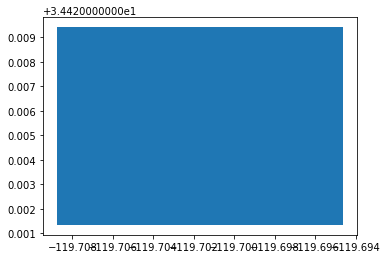

In [13]:
aoi.plot()

### UPDATING CRS

One of our goals is to clip the RGB and NIR rasters to this area of interest. This means just selecting the subset of the rasters that is within that rectangle. Our main obstacle here is that the shapefile and rasters have differnt CRSs, let's confirm that:

In [14]:
print('aoi CRS: ', aoi.crs)
print('nir CRS: ', nir.rio.crs)
print('rgb CRS: ', rgb.rio.crs)

aoi CRS:  epsg:4326
nir CRS:  EPSG:26911
rgb CRS:  EPSG:26911


Fortunately doing the transformation is pretty straightforward, we can use the geodatafram `.to_crs()` method:

In [15]:
aoi = aoi.to_crs(rgb.rio.crs)
print('matched crs?',  aoi.crs == rgb.rio.crs)
aoi.crs

matched crs? True


<Derived Projected CRS: EPSG:26911>
Name: NAD83 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Since both objects now have the same CRS, the computer knows how to locate them correctly on the Earth. We can even look at them both together on a plot:

<AxesSubplot:title={'center':'spatial_ref = 0'}, xlabel='x', ylabel='y'>

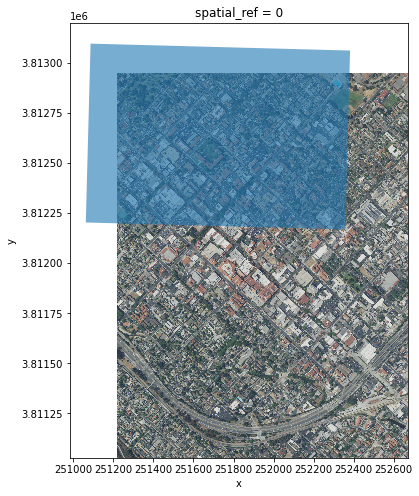

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
rgb.plot.imshow(ax=ax)
aoi.plot(ax=ax, alpha=0.6)

# 3. Clip rasters using the shapefile

It is quite common that the raster data you have in hand is too large to process, or not all the pixels are relevant to your area of interest (AoI). In both situations, we should consider cropping your raster data before performing data analysis.

The `clip_box` function allows one to crop a raster by the min/max of the x and y coordinates.

In [17]:
rgb_small = rgb.rio.clip_box(*aoi.total_bounds)
print('original shape: ', rgb.shape)
print('reduced shape: ', rgb_small.shape)

original shape:  (3, 3208, 2419)
reduced shape:  (3, 1305, 1941)


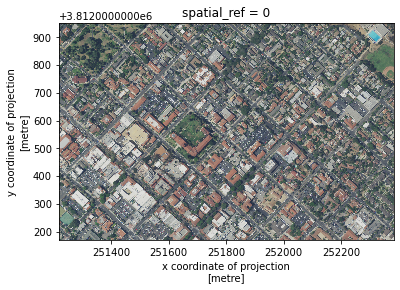

In [18]:
rgb_small.plot.imshow()

In [19]:
nir_small = nir.rio.clip_box(*aoi.total_bounds)
print('original shape: ', nir.shape)
print('reduced shape: ', nir_small.shape)

original shape:  (3208, 2419)
reduced shape:  (1305, 1941)


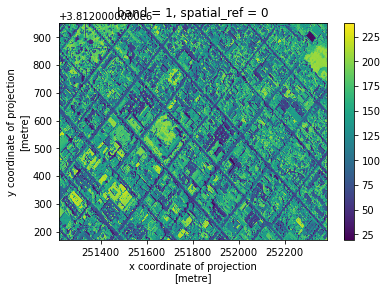

In [20]:
nir_small.plot()

# 4. Compute Normalized Difference Vegetation Index (NDVI)

We often want to combine values of and perform calculations on rasters to create a new output raster. In this case we are interested in computing the Normalized Difference Vegetation Index over our area of interest. The NDVI is an index commonly used to check if an area has live green vegetation or not. It can also show the difference between water, plants, bare soil, and human-made structures, among other things. 

According to the [Earth Observing System](https://eos.com/blog/ndvi-faq-all-you-need-to-know-about-ndvi/)
> The results of the NDVI calculation range from -1 to 1. Negative values correspond to areas with water surfaces, manmade structures, rocks, clouds, snow; bare soil usually falls within 0.1- 0.2 range; and plants will always have positive values between 0.2 and 1. Healthy, dense vegetation canopy should be above 0.5, and sparse vegetation will most likely fall within 0.2 to 0.5. 

The NDVI is calculated using the near-infrared and red bands of the satellite image. The formula is

$$NDVI = \frac{NIR - Red}{NIR + Red}.$$

We can perform raster calculations by subtracting (or adding, multiplying, etc.) two rasters, just as if they were arrays. In the geospatial world, we call this “raster math”, and typically it refers to operations on rasters that have the same width and height (including nodata pixels). 

## SELECTING A SINGLE RASTER BAND
To compute the NDVI we just need the red band from the rgb raster. We can select it using the `.sel()` function and specifying the value of the coordinate we want to select. We can see this is now a raster with a single band.

In [21]:
red = rgb_small.sel(band=1)
red

<xarray.DataArray (y: 1305, x: 1941)>
[2533005 values with dtype=uint8]
Coordinates:
    band         int64 1
  * x            (x) float64 2.512e+05 2.512e+05 ... 2.524e+05 2.524e+05
  * y            (y) float64 3.813e+06 3.813e+06 ... 3.812e+06 3.812e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

*This is some technical stuff...*

**TL;DR**: we need to change the rasters' data type from `uint8` (small integers) to `int16` (bigger integers) to properly calculate the NDVI.

When I was preparing this notebook I calculated the NDVI with the red band and nir raster we have so far. The data types in both of them is `uint8`, a very small data type that only holds integers from 0 up to 255. Notice that in the NDVI formula we have to add NIR + Red. So if both NIR and Red are very close to 255, when we add them this overflows the `unit8` datatype and we get garbage out of the calculation. Weirdly, I thought the data conversion to a bigger integer type would be handled automatically, but it did not. That is why we will have to manually convert both rasters into a `int16`, which will be big enough to hold all the numbers that appear in the calculations.



In [22]:
red16 = red.astype('int16')
nir16 = nir_small.astype('int16')
print('RED: original dtype:', rgb_small.dtype, '.... converted dtype:', red16.dtype)
print('NIR: original dtype:', nir.dtype, '.... converted dtype:', nir16.dtype)

RED: original dtype: uint8 .... converted dtype: int16
NIR: original dtype: uint8 .... converted dtype: int16


Now we can calculte the NDVI, and we just use the rasters as if they were numbers (or arrays), the calculation will be done pixel by pixel. 

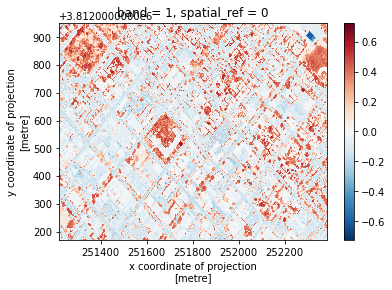

In [23]:
ndvi = (nir16 - red16)/(nir16+red16)
ndvi.plot()

Remember that plants will always have positive NDVI values between 0.2 and 1. Can you spot the Courthouse and the Alameda Park?

# 5. Save our NDVI raster
To save our NDVI raster as a .tif file we will use the `rasterio` package. The way we do it might be a bit odd if this is the first time you do it. We first need to open a file using `rasterio.open()` and then we write on that file using `.write()`. The `rasterio.open()` function takes in a lot of parameters:
- file path where we want to save the raster
- 'w' tells the open function we will open a file in writing mode
- driver is the format to save the raster (.tif is only one possible format for rasters)
- raster attributes (we had explored them the beginning of the notebook!)

In [24]:
ndvi_fp = "/home/jovyan/PlanetComp_NAIP2/ndvi.tif"

with rasterio.open(
    ndvi_fp,  # file path
    'w',           # w = write
    driver='GTiff', # format
    height=ndvi.shape[0], 
    width=ndvi.shape[1],
    count=1,  # number of raster bands in the dataset
    dtype=ndvi.dtype,
    crs=ndvi.rio.crs,
    transform=ndvi.rio.transform(),
) as dst:
    dst.write(ndvi.values, 1)

I usually like to reopen the file just to make sure that everythin worked correctly.

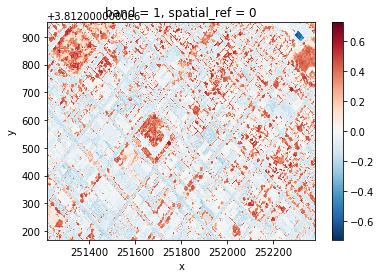

In [25]:
ndvi_check = rioxr.open_rasterio(ndvi_fp)
#print(nir_check.shape)
ndvi_check.plot()

## All looks good!